In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.constants import elementary_charge

from nils.reconstruction_module import cleanup_formfactor
from nils.reconstruction_module_after_diss import master_recon
from nils.simulate_spectrometer_signal import get_crisp_signal


In [2]:
data_dir = Path("data/zihan")
data_filepath = data_dir / "data_20220905_full.pkl"
df = pd.read_pickle(data_filepath)


In [3]:
len(df)


32000

In [4]:
i = 0


In [5]:
df.loc[i, ["chirp", "curv", "skew", "chirpL1", "chirpL2"]]


chirp        -7.44
curv         281.3
skew       45442.0
chirpL1     -13.43
chirpL2       2.11
Name: 0, dtype: object

In [6]:
df.loc[i, "slice_width"]


3.026108006382898e-07

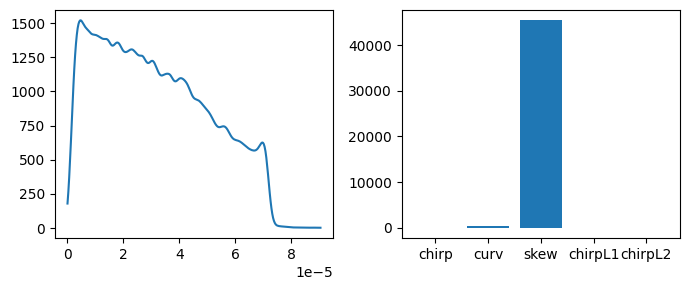

In [7]:
# ss = np.linspace(i, 0.1e-3, num=300)  # * df.loc[0, "slice_width"]
ss = np.arange(300) * df.loc[i, "slice_width"]
currents = np.array(df.loc[i, "slice_I"])

rf_setting_names = ["chirp", "curv", "skew", "chirpL1", "chirpL2"]
rf_settings = df.loc[i, rf_setting_names].values.astype("float")

plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(ss, currents)
plt.subplot(1, 2, 2)
plt.bar(rf_setting_names, rf_settings)
plt.tight_layout()
plt.show()


In [8]:
def current2formfactor(
    ss: np.ndarray,
    currents: np.ndarray,
    grating: str = "both",
    clean: bool = False,
    n_shots: int = 10,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Convert a currents `current` over `s` to it the corresponding cleaned formfactor
    produced by CRISP with `grating` active.
    """

    frequencies, formfactor, formfactor_noise, detlim = get_crisp_signal(
        ss, currents, n_shots=n_shots, which_set=grating
    )

    if clean:
        frequencies, formfactor, _ = cleanup_formfactor(
            frequencies, formfactor, formfactor_noise, detlim, channels_to_remove=[]
        )

    return frequencies, formfactor


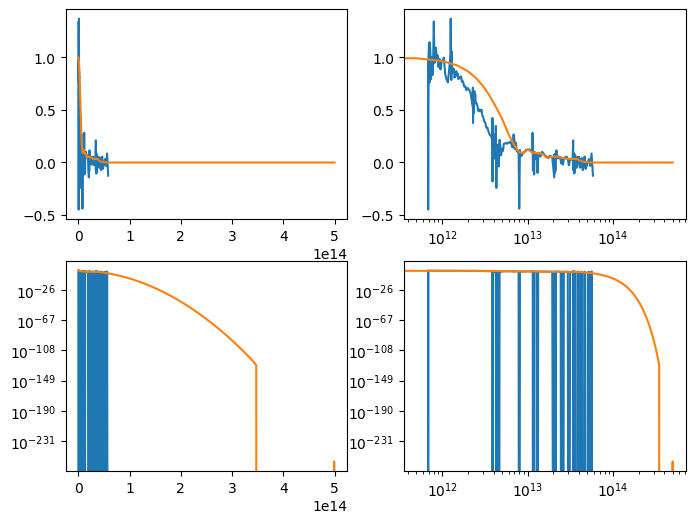

In [9]:
frequencies, formfactor = current2formfactor(
    ss, currents, grating="both", n_shots=1, clean=False
)
clean_frequencies, clean_formfactor = current2formfactor(
    ss, currents, grating="high", clean=True
)

plt.figure(figsize=(8, 6))
plt.subplot(221)
plt.plot(frequencies, formfactor)
plt.plot(clean_frequencies, clean_formfactor)
plt.subplot(222)
plt.plot(frequencies, formfactor)
plt.plot(clean_frequencies, clean_formfactor)
plt.xscale("log")
plt.subplot(223)
plt.plot(frequencies, formfactor)
plt.plot(clean_frequencies, clean_formfactor)
plt.yscale("log")
plt.subplot(224)
plt.plot(frequencies, formfactor)
plt.plot(clean_frequencies, clean_formfactor)
plt.xscale("log")
plt.yscale("log")
plt.show()


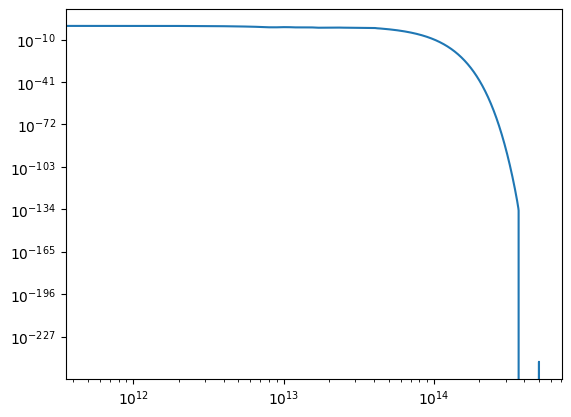

In [10]:
frequencies, formfactor = current2formfactor(ss, currents, grating="high", clean=True)

plt.plot(frequencies, formfactor)
plt.loglog()
plt.show()


0
1
Convergiert: 1


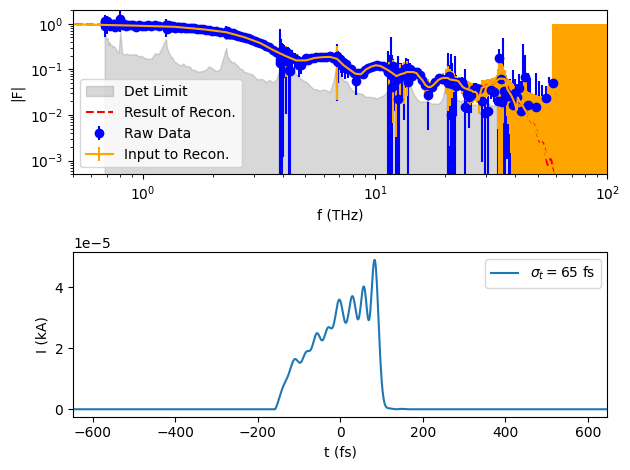

In [11]:
frequencies, formfactor, formfactor_noise, detlim = get_crisp_signal(
    ss, currents, n_shots=10, which_set="both"
)

reconstructed = master_recon(
    frequencies,
    formfactor,
    formfactor_noise,
    detlim,
    charge=40000 * elementary_charge,
)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler


In [13]:
rfs_dataset = df[["chirp", "chirpL1", "chirpL2", "curv", "skew"]].values

rfs_dataset.shape


(32000, 5)

In [14]:
ss_dataset = np.stack(
    [np.linspace(0, 300 * df.loc[i, "slice_width"], num=300) for i in df.index]
)
ss_dataset.shape


(32000, 300)

In [15]:
lengths = ss_dataset.max(axis=1) - ss_dataset.min()
lengths.shape


(32000,)

In [16]:
currents_dataset = np.stack(df["slice_I"].values)
currents_dataset.shape


(32000, 300)

In [17]:
stacked_currents_dataset = np.stack([ss_dataset, currents_dataset], axis=1)
stacked_currents_dataset.shape


(32000, 2, 300)

In [18]:
formfactors_dataset = np.array(
    [
        current2formfactor(ss, currents, grating="both", n_shots=1, clean=False)
        for ss, currents in zip(ss_dataset, currents_dataset)
    ]
)
formfactors_dataset.shape


(32000, 2, 240)

In [19]:
formfactors_dataset_reshaped = formfactors_dataset.reshape(-1, 480)
formfactors_dataset_reshaped.shape


(32000, 480)

In [20]:
X_formfactors = formfactors_dataset[:, 1]
X_rf_settings = df[["chirp", "curv", "skew", "chirpL1", "chirpL2"]].values.astype(
    "float"
)

X = np.concatenate([X_formfactors, X_rf_settings], axis=1)
y = stacked_currents_dataset


In [21]:
X.shape, y.shape


((32000, 245), (32000, 2, 300))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


In [23]:
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)


In [24]:
knn = KNeighborsRegressor(n_neighbors=5).fit(
    X_train_scaled[:], y_train.reshape(-1, 600)
)


In [25]:
X_test_scaled = X_scaler.transform(X_test)


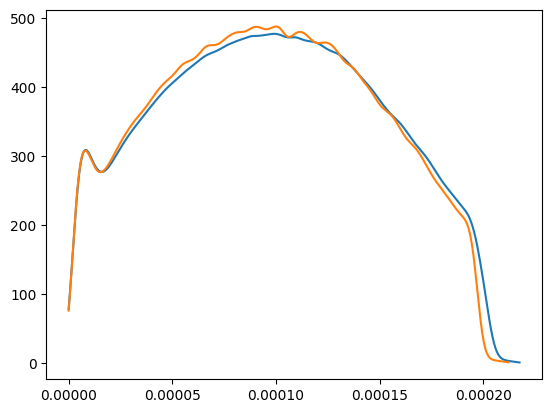

In [26]:
i = 1
pred = knn.predict(X_test_scaled[i : i + 1])
ss, currents = pred.reshape(2, 300)

plt.plot(ss, currents)
plt.plot(y_test[i, 0], y_test[i, 1])
plt.show()


In [27]:
len(df)


32000

In [28]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)


In [29]:
len(df_train), len(df_test)


(25600, 6400)

In [30]:
data_dir


PosixPath('data/zihan')

In [31]:
df_train.to_pickle(data_dir / "train.pkl")
df_test.to_pickle(data_dir / "test.pkl")


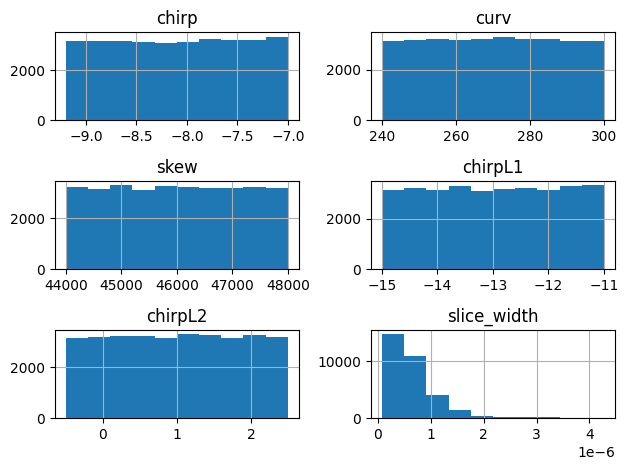

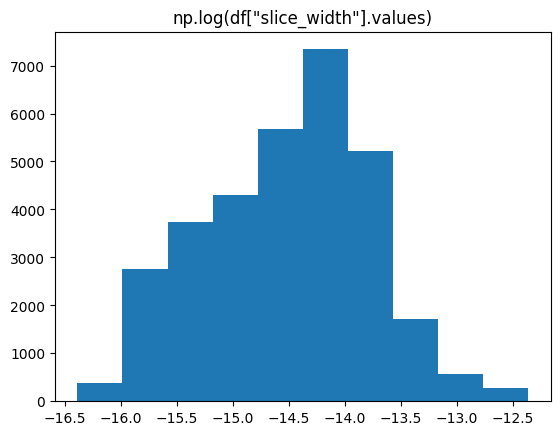

In [35]:
df[rf_setting_names + ["slice_width"]].describe()

df[rf_setting_names + ["slice_width"]].hist()
plt.tight_layout()

plt.figure()
plt.hist(np.log(df["slice_width"].values))
plt.title('np.log(df["slice_width"].values)')
plt.show()


np.mean(slice_I_array) = 658.3611172108882
np.std(slice_I_array) = 1244.3372296346693
np.min(slice_I_array) = 0.0
np.max(slice_I_array) = 17517.023754702856


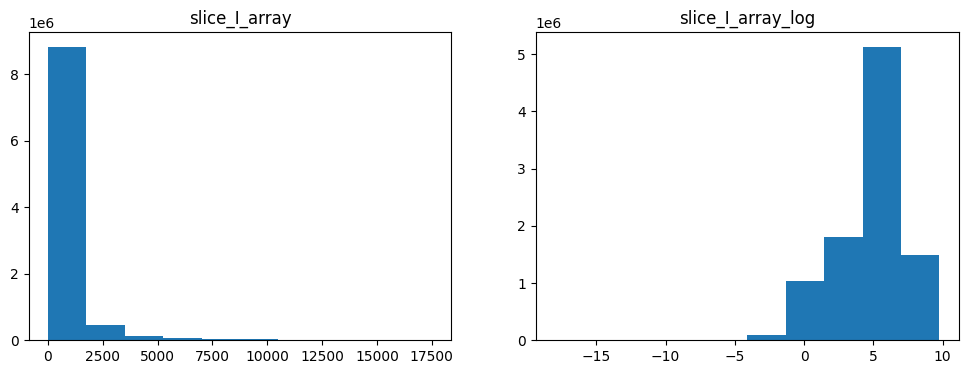

In [45]:
slice_I_array = np.stack(df["slice_I"].values)
print(f"{np.mean(slice_I_array) = }")
print(f"{np.std(slice_I_array) = }")
print(f"{np.min(slice_I_array) = }")
print(f"{np.max(slice_I_array) = }")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(slice_I_array.flatten())
plt.title("slice_I_array")
plt.subplot(1, 2, 2)
slice_I_array_log = np.log(
    np.delete(slice_I_array.flatten(), slice_I_array.flatten() == 0)
)
plt.hist(slice_I_array_log)
plt.title("slice_I_array_log")
plt.show()


np.mean(formfactors_array) = 0.2948569285644001
np.std(formfactors_array) = 0.40047002070349796
np.min(formfactors_array) = -2.397708315570599
np.max(formfactors_array) = 2.817055953213272


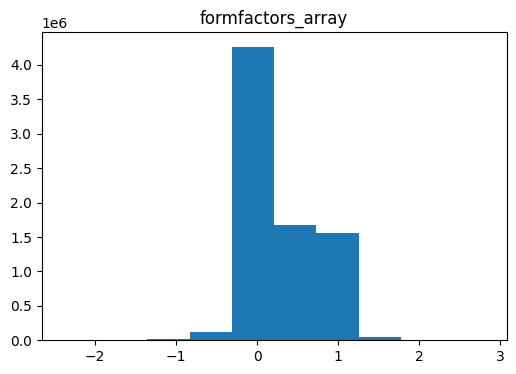

In [46]:
formfactors_array = formfactors_dataset[:, 1]
print(f"{np.mean(formfactors_array) = }")
print(f"{np.std(formfactors_array) = }")
print(f"{np.min(formfactors_array) = }")
print(f"{np.max(formfactors_array) = }")

plt.figure(figsize=(6, 4))
plt.hist(formfactors_array.flatten())
plt.title("formfactors_array")
plt.show()
